## Assignment 5:1D CNN,  RNNs  and 2D CNN  with Applications 
### Adithya Jayan 181EC102 | Anvith M 181EC105

###### Importing libraries

In [1]:
import numpy as np
import keras
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.keras import TqdmCallback
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
%load_ext tensorboard

##### Q. 1. Build a  1D CNN model from scratch to recognize human activity using HAR dataset  (https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) (split dataset into training dataset (80%) and  testing dataset (20%) ). For implementation, use a Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Focal loss function
- (i)Visualize HAR dataset
- (ii) Plot a comparative loss curve for at least 200 epochs.
- (iii)Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test dataset and ROC curve
- (iv)  Implement above 1D CNN model with Keras Library and verify the above results. 

###### Read data

In [2]:
path = "Data/UCI HAR Dataset/UCI HAR Dataset/"
x_train = pd.read_csv(path+'train/X_train.txt',header=None,delim_whitespace=True)
y_train = pd.read_csv(path+'train/Y_train.txt',header=None,delim_whitespace=True)
x_test = pd.read_csv(path+'test/X_test.txt',header=None,delim_whitespace=True)
y_test = pd.read_csv(path+'test/Y_test.txt',header=None,delim_whitespace=True)
print(x_train.info())
x_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB
None


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [3]:
print(y_train.info())
y_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB
None


,0
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


###### Define functions

In [4]:
#Function for debugging
def check_nan(Layer_name,**variables):
    if any(np.isnan(val).any() for val in variables.values()):
        print("************* nan detected at {}! *************\n".format(layer_name))
        for key,value in variables.items():
            print("Variable ",key,":")
            print(value,"\n")

## Required layers

# Conv2D (Used as 1D)
class conv2d_layer:
    def __init__(self,shape,n,anything_else = None):
        self.w = np.random.rand(n,shape[0],shape[1],shape[2])/(np.product(shape)+1)
        self.b = np.random.rand(n)/(np.product(shape)+1)
        self.n = n
        
    def forward(self,Image):    
        
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape

        _ , x_k , y_k = self.w[0].shape

        out_x = x-x_k+1
        out_y = y-y_k+1
        
        output = []
        
        for pos in range(self.n):
            out = np.zeros((out_x,out_y))
            
            for i in range(out_x):
                for j in range(out_y):
                    out[i,j] = np.sum(Image[:,i:i+x_k,j:j+y_k]*self.w[pos]) + self.b[pos]
            output = output + [out]
        output = np.array(output)      
            
#         check_nan(Layer_name = "conv2d_layer forward step",
#                   output = output,
#                   Image = Image,
#                   self_Weight = self.w,
#                   self_Bias = self.b)
        
        return output
    
    def reverse(self,Image,Errors):
        
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape
        _ ,x_k,y_k = self.w[0].shape
        err_x,err_y = Errors[0].shape
        
        output = np.zeros_like(Image,Errors.dtype)
        for layer in range(self.n):
            for i in range(err_x):
                for j in range(err_y):
                    output[:,i:i+x_k,j:j+y_k] += Errors[layer,i,j]*self.w[layer]
                    self.w[layer] = self.w[layer] - Errors[layer,i,j]*Image[:,i:i+x_k,j:j+y_k]
                    self.b[layer] = self.b[layer] - Errors[layer,i,j]
                
#         check_nan(Layer_name = "conv2d_layer reverse step",
#                   output = output,
#                   Image = Image,
#                   Errors = Errors,
#                   Weights = self.w,
#                   Bias = self.b)
        
        return output
    
    def display(self):
        print("\n**********Convolution Parameters**********")
        print("Weights are:\n", self.w)
        print("Bias is:\n ", self.b)
        print("#Kernels is:\n ", self.n)
        
# tanh
class tanh:
    
    def forward(self,Input):
        exp = np.exp(-2*Input)
        output = (1-exp)/(1+exp)
        
#         check_nan(Layer_name = "tanh forward step",
#           Input = Input,
#           output = output)
            
        return output
    
    def reverse(self,Input,Errors):
        der = 1-np.square(self.forward(Input))
        output = der*Errors
        
#         check_nan(Layer_name = "tanh reverse step",
#                   Input = Input,
#                   Errors = Errors,
#                   output = output,
#                   der = der)
        
        return output
    
# AveragePooling2D (Used as 1D)
class AveragePooling2D:
    
    def __init__(self,shape,stride,anything_else = None):
        self.shape = shape
        self.stride = stride
        
    def forward(self,Image):  
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape
        s=self.stride
        x_k,y_k = self.shape
        
        out_x = (x-x_k)//s+1
        out_y = (y-y_k)//s+1

        output = []
        for pos in range(Image.shape[0]):
            
            out = np.zeros((out_x,out_y))

            for i in range(out_x):
                for j in range(out_y):
                    out[i,j] = np.mean(Image[0][i*s:i*s+x_k,j*s:j*s+y_k])
            output = output + [out]
            
        output = np.array(output)
        
        return output
    
    def reverse(self,Image,Errors):
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
        
        x,y = Image[0].shape
        x_k,y_k = self.shape
        err_x,err_y = Errors[0].shape
            
        output = []
        for pos in range(Image.shape[0]):

            out = np.zeros_like(Image[pos],Errors.dtype)

            for i in range(err_x):
                for j in range(err_y):
                    out[i:i+x_k,j:j+y_k] += Errors[pos,i,j]/(x_k*y_k)
            output = output + [out]
        output = np.array(output)
        return output
    
# Flatten
class flatten():
    
    def forward(self,Image):
        output = np.reshape(Image,np.product(Image.shape))
        return output
    
    def reverse(self,Image,errors):
        output = np.reshape(errors,Image.shape)
        return output

# Dense
class fully_connected():
    def __init__(self,input_size,n):
        
        self.w = np.random.rand(n,input_size)/(input_size+1)
        self.b = np.random.rand(n)/(input_size+1)
        self.n = n
    
    def forward(self,Input):
        output = []
        for layer in range(self.n):
            out = np.dot(Input,self.w[layer]) + self.b[layer]
            output = output + [out]
        output = np.array(output)
        return output
    
    def reverse(self,Input,errors):
        
        output = np.zeros_like(Input)
        for layer in range(self.n):
            self.w[layer] = self.w[layer] - errors[layer]*Input
            self.b[layer] = self.b[layer] - errors[layer]
            output = output + errors[layer]*self.w[layer]   
        output = np.array(output)
        return output
    
# softmax
class softmax():
    
    def forward(self,Input):

        Numerator = np.exp(Input)
        output = Numerator/sum(Numerator)
        
        return (output)
    
    def reverse(self,Input,errors):
            
        Soft = self.forward(Input)
        
        Soft_list = np.array([list(Soft)] * len(Soft))
        derivative = Soft_list.T*(np.identity(len(Soft)) - Soft_list)
        
        output = np.matmul(errors,derivative)
        
        return output

def SoftmaxLoss(truth,predicted):
    
    loss = -1* np.sum(truth*np.log(predicted))
    
    Numerator = np.exp(predicted)
    softmax = Numerator/sum(Numerator)
        
    grad = softmax
    grad[truth == 1] = softmax[truth == 1] - 1
    
    return (loss,grad)
# Must work for both adam as well as SGD algos

###### Defining custom model

In [5]:
Model = [] #Input = 1*561

#Layer 0
Model = Model + [conv2d_layer((1,10,1),50)] #Out = 50*552*1

#Layer 1
Model = Model + [tanh()] #Out = 50*552*1

#Layer 2
Model = Model + [AveragePooling2D((3,1),3)] #Out = (50, 184, 1)

#Layer 3
Model = Model + [conv2d_layer((50,5,1),16)] #Out = (16, 180, 1)

#Layer 4
Model = Model + [tanh()] #Out = (16, 180, 1)

#Layer 5
Model = Model + [AveragePooling2D((3,1),3)]# Out = (16, 60, 1)

#Layer 6
Model = Model + [conv2d_layer((16,5,1),1)] #Out = (1, 56, 1)

#Layer 7
Model = Model + [tanh()] #Out = (1, 56, 1)

#Layer 8
Model = Model + [flatten()] #Out = 56

#Layer 9
Model = Model + [fully_connected(56,6)] #Out = 6

#Layer 10
Model = Model + [tanh()] #Out = 6

# #Layer 11
# Model = Model + [fully_connected(6,6)] #Out = 10

#Layer 12
Model = Model + [softmax()] #Out = 6

###### Training

In [6]:
epochs = 3
Recorded_loss = []
Learning_rate = 0.01

x_train,y_train = shuffle(x_train,y_train)

x_train = np.array(x_train[:50])
y_train = np.array(y_train[:50])


n_layers = len(Model)
for ep in tqdm.tqdm(range(epochs),leave=True,desc = "Epochs"):
    
    Data = tqdm.tqdm(zip(x_train,y_train),total = len(y_train),leave=False,desc = "Images")
    
    for Input_img,truth in Data:
        truth_onehot = np.array([0]*6)
        truth_onehot[truth-1] = 1
        outputs = [np.reshape(Input_img,(1,Input_img.shape[0],1))]
        
        for i in range(n_layers):
            out = Model[i].forward(outputs[-1])
#             print(i,out.shape)
#             print(out)
            outputs += [out.copy()]
            
    
        Loss, error = SoftmaxLoss(truth_onehot,outputs[-1])
#         print(Loss,error)
        error = error * Learning_rate
        Recorded_loss += [Loss] 
        
        Data.set_description("Current loss is: {}".format(np.round(Loss,5)))
        Data.refresh()
        
#         print("\n\nTruth:\n",truth_onehot,"\nPrediction:\n",outputs[-1])
#         print("Epoch: ",ep ,"\nLoss:",Loss)
        
        error = [error]
        for i in range(n_layers-1,-1,-1):
#             print("Reversing layer {}.".format(i))
            out = Model[i].reverse(outputs[i],error[-1])
            error += [out.copy()]
            
#         error.reverse()
#         for i in range(len(error)): 
#             print("\n*******************Output of layer {} is:*******************\n\n".format(i-1),outputs[i])
#             print("\n*******************Gradient entering layer {} output:*******************\n\n".format(i-1),error[i])
    
    Data.set_description("Completed")
    Data.refresh()

###### Plot loss

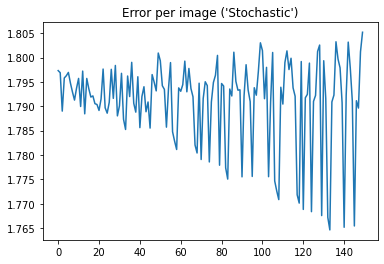

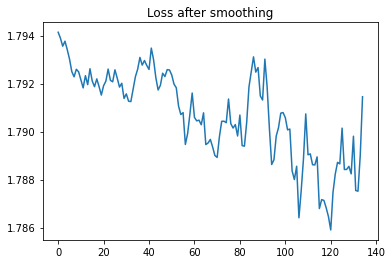

In [7]:
plt.plot(Recorded_loss)
plt.title("Error per image ('Stochastic')")

val = 15
Avg_loss = []
for i in range(len(Recorded_loss)-val):
    Avg_loss +=  [np.mean(Recorded_loss[i:i+val])]

plt.figure()
plt.title("Loss after smoothing")
plt.plot(Avg_loss)

###### Confusion matrix

In [8]:
#Display confusion Matrix

prediction = []

test_set = np.array(x_test[0:50])
y_test = np.array(y_test[0:50])
y_test = np.reshape(y_test,y_test.shape[0])
print(y_test)
for Input_img in tqdm.tqdm(test_set,total = len(test_set)):
    outputs = [np.reshape(Input_img,(1,Input_img.shape[0],1))]
    for i in range(n_layers):
        out = Model[i].forward(outputs[-1])
        outputs += [out.copy()]
    prediction += [np.argmax(out)]
    
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(prediction, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


Predicted,5
Actual,
4,19
5,31


##### Q2. Python Implementation  of LSTM  from scratch  for   Binary to  Octal  conversion. 

###### Create data

In [9]:
temp = [np.random.randint(1023) for i in range(1000)]
x = np.array([[[int(j)] for j in '{0:010b}'.format(i)] for i in temp])
y = np.array([[[int(j)] for j in '{0:04o}'.format(i)] for i in temp])

In [10]:
print(x.shape,y.shape)

(1000, 10, 1) (1000, 4, 1)


###### Define and train model

In [11]:
keras.backend.clear_session()

In [12]:
# create and fit the LSTM network

model = keras.models.Sequential()
model.add(keras.layers.LSTM(10, input_shape=(10,1)))
model.add(keras.layers.Dense(10,activation ="tanh"))
model.add(keras.layers.Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

###### Test model manually

In [13]:
test = np.array([[[0],[0],[0],[0],[0],[0],[0],[1],[1],[0]]])
print("Binary: ",test)
prediction = model.predict(test)
print("Octal: ",np.round(prediction[0]))

Binary:  [[[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [1]
  [0]]]
Octal:  [ 0. -0.  0.  6.]


##### Q.3. Implement A CNN-RNN (LSTM)Framework  using  (Keras/Tensorflow/Pytorch) for CropYield Prediction (reference  paper, and dataset attached and other related  dataset is available at https://github.com/saeedkhaki92/CNN-RNN-Yield-Prediction) . For implementation, use a Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for  RMSE as l loss function
- (i) Plot a comparative loss curve for at least 100 epochs.
- (ii) Compare  for Soybean  and Corn  yield prediction performance (RMSE and Correlation Coefﬁcient)  for years 2016, 2017,and 2018 of 1D CNN, RNN(LSTM), and CNN- RNN(LSTM)


###### Read data

In [14]:
path = "Data/"
x_corn = pd.read_csv(path+'corn_samples.txt')
y_corn = pd.read_csv(path+'corn_samples.txt')
x_soy = pd.read_csv(path+'soybean_samples.txt')
y_soy = pd.read_csv(path+'soybean_samples.txt')
print(x_corn.info())
x_corn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Columns: 397 entries, loc_ID to P_16
dtypes: float64(358), int64(39)
memory usage: 4.5 MB
None


,loc_ID,year,yield,W_1_1,W_1_2,W_1_3,W_1_4,W_1_5,W_1_6,W_1_7,...,P_7,P_8,P_9,P_10,P_11,P_12,P_13,P_14,P_15,P_16
0,0,1980,82.0,0.274725,0.000000,1.615385,0.395604,0.967033,0.736264,1.153846,...,38,40,8,4,0,0,0,0,0,0
1,0,1981,116.0,0.604396,0.000000,0.043956,0.000000,0.857143,1.824176,0.000000,...,13,30,16,11,12,7,3,0,0,0
2,0,1982,124.0,2.098901,0.384615,1.681319,0.527473,6.340659,1.593407,1.868132,...,47,14,5,2,1,0,0,0,0,0
3,0,1983,46.0,0.000000,0.000000,0.000000,1.032967,4.373626,0.351648,0.263736,...,11,24,22,17,6,5,3,0,0,0
4,0,1984,103.0,0.000000,0.043956,0.197802,0.461538,0.142857,0.670330,4.615385,...,6,35,33,10,4,8,0,0,0,0


###### For Corn data

In [15]:
X_train = np.array(x_corn.drop(["yield","loc_ID","year"],axis = 1)) 
Y_train = np.array(x_corn["yield"])

In [16]:
for i in range(X_train.shape[-1]):
    diff = np.max(X_train[:,i]) - np.min(X_train[:,i])
    if(diff != 0):
        X_train[:,i] = (X_train[:,i]-np.mean(X_train[:,i]))/diff
    else:
        X_train[:,i] = 0
        
Y_train = Y_train/np.max(Y_train)

###### Define model

In [17]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(394)))
model.add(keras.layers.Reshape((394,1)))

model.add(keras.layers.Conv1D(64, activation='relu', kernel_size=(3)))
model.add(keras.layers.Conv1D(64, activation='relu', kernel_size=(3)))
model.add(keras.layers.MaxPool1D(pool_size=(2), strides=(2), padding='valid'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Reshape((8, 8)))

model.add(keras.layers.LSTM(8, return_sequences=True))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation=None))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 394, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 392, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 390, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 195, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3195136   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1

###### Train model

In [18]:
#tfa.losses.SigmoidFocalCrossEntropy()
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, Y_train, epochs=2, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

##### For Soy Data

In [19]:
X_train = np.array(x_soy.drop("yield",axis = 1)) 
Y_train = np.array(x_soy["yield"])

In [20]:
for i in range(X_train.shape[-1]):
    diff = np.max(X_train[:,i]) - np.min(X_train[:,i])
    if(diff != 0):
        X_train[:,i] = (X_train[:,i]-np.mean(X_train[:,i]))/diff
    else:
        X_train[:,i] = 0
        
Y_train = Y_train/np.max(Y_train)

###### Define model

In [21]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(394)))
model.add(keras.layers.Reshape((394,1)))

model.add(keras.layers.Conv1D(64, activation='relu', kernel_size=(3)))
model.add(keras.layers.Conv1D(64, activation='relu', kernel_size=(3)))
model.add(keras.layers.MaxPool1D(pool_size=(2), strides=(2), padding='valid'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Reshape((8, 8)))

model.add(keras.layers.LSTM(8, return_sequences=True))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation=None))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 394, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 392, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 390, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 195, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3195136   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1

###### Train model

In [22]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, Y_train, epochs=2, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

##### Q4. Python Implementation  of GRU  from scratch  for   Binary to Deceimal conversion. 

###### Create data

In [23]:
temp = [np.random.randint(1023) for i in range(5000)]
x = np.array([[[int(j)] for j in '{0:010b}'.format(i)] for i in temp])
y = np.array([[[int(j)] for j in '{0:04d}'.format(i)] for i in temp])

In [24]:
print(x.shape,y.shape)

(5000, 10, 1) (5000, 4, 1)


###### Define and train model

In [25]:
keras.backend.clear_session()

In [26]:
# create and fit the GRU network

model = keras.models.Sequential()
model.add(keras.layers.GRU(15, input_shape=(10,1),activation = 'tanh'))
model.add(keras.layers.Dense(15))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=2, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

###### Test data manually

In [27]:
test = np.array([[[0],[0],[0],[0],[0],[0],[0],[1],[1],[1]]])
print("Binary: ",test)
prediction = model.predict(test)
print("Octal: ",np.round(prediction[0]))

Binary:  [[[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [1]
  [1]]]
Octal:  [-0. -1.  2.  4.]


### Q. 5. Build a CNN(AleNet)model  (using Keras/Tensorflow/Pytorch)  to recognize breast cancer from Breast Dataset (Use Sklearn Dataset and  split dataset into training dataset (80%) and  testing dataset (20%) ). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the  CNNmodel for Focal loss function.
- (i) Plot a comparative loss curve for at least 200 epochs.
- (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test datset and ROC curve for each loss function.


###### Read data

In [28]:
#Import data

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
list(data.target_names)


#Split data
X = data['data']
Y = data['target']
col_names = data['target_names']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size =0.2)

In [29]:
print(X_train.shape,Y_train.shape)

(455, 30) (455,)


###### Define model

In [30]:
keras.backend.clear_session()

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Reshape((30,1,1),input_shape=(30,)))
# model.add(keras.layers.Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='relu'))
# model.add(keras.layers.Conv2D(filters=5, kernel_size=(5,1), padding='same', activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation = 'sigmoid'))
model.add(keras.layers.Dense(5,activation = 'sigmoid'))
model.add(keras.layers.Dense(3,activation = 'sigmoid'))
model.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 1, 1)          0         
_________________________________________________________________
flatten (Flatten)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 387
Trainable params: 387
Non-trainable params: 0
__________________________________________________________

###### Train model

In [33]:
model.compile(loss='bce', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

###### Plot confusion matrix for predicted results vs ground truth

In [34]:
prediction = np.reshape(np.round(model.predict(X_test)),-1)

y_actu = pd.Series(Y_test, name='Actual')
y_pred = pd.Series(prediction, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0.0,1.0
Actual,,
0,18,30
1,0,66
